# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import lightgbm as lgbm
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OrdinalEncoder
import time
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, cross_val_predict

## Подготовка данных

In [ ]:
data =  pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
data.duplicated().sum()

4

In [ ]:
duplicates = data[data.duplicated(keep=False)]  # keep=False отмечает все копии
duplicates_sorted = duplicates.sort_values(by=data.columns.tolist())
print(duplicates_sorted)

                DateCrawled  Price VehicleType  RegistrationYear Gearbox  \
88087   2016-03-08 18:42:48   1799       coupe              1999    auto   
171088  2016-03-08 18:42:48   1799       coupe              1999    auto   
41529   2016-03-18 18:46:15   1999       wagon              2001  manual   
325651  2016-03-18 18:46:15   1999       wagon              2001  manual   
90964   2016-03-28 00:56:10   1000       small              2002  manual   
231258  2016-03-28 00:56:10   1000       small              2002  manual   
187735  2016-04-03 09:01:15   4699       coupe              2003    auto   
258109  2016-04-03 09:01:15   4699       coupe              2003    auto   

        Power   Model  Kilometer  RegistrationMonth  FuelType          Brand  \
88087     193     clk      20000                  7    petrol  mercedes_benz   
171088    193     clk      20000                  7    petrol  mercedes_benz   
41529     131  passat     150000                  7  gasoline     volkswage

In [ ]:
# код ревьюера (посчитаем для ускорения на части данных)
data=data.sample(frac=0.07)

In [ ]:
data = data.drop_duplicates(keep='first')

In [ ]:
data.duplicated().sum()

0

In [ ]:
def show_rows(data_frame):
    for column in data_frame.columns:
        print('Уникальные значения столбца', column)
        print(data_frame[column].unique())

In [ ]:
show_rows(data)

Уникальные значения столбца DateCrawled
['2016-03-30 00:36:21' '2016-03-10 00:57:47' '2016-03-16 19:42:07' ...
 '2016-03-16 18:45:09' '2016-04-02 16:59:30' '2016-03-17 15:37:18']
Уникальные значения столбца Price
[6250  500  750 ... 7998  344 6798]
Уникальные значения столбца VehicleType
['sedan' 'wagon' 'small' 'coupe' 'bus' 'convertible' nan 'other' 'suv']
Уникальные значения столбца RegistrationYear
[2004 1996 1995 1999 2002 2001 2003 2007 1990 2011 2008 2017 1998 1994
 2010 2005 2000 2013 1991 1997 2009 2014 2015 2006 2016 1989 2018 1986
 1985 1970 2012 1992 1976 1984 1975 1993 1988 1974 1987 1980 1961 1973
 1978 1968 1982 1983 1971 1964 1959 1972 1966 1800 1969 1977 1979 1400
 1981 1953 1958 5911 5000 1965 6000 1960 1956 1967 1910 1957 1962 1951
 2019 1929 1600 1963 1000 1942 9996 1955 1941 1950 1943 1933]
Уникальные значения столбца Gearbox
['auto' 'manual' nan]
Уникальные значения столбца Power
[    0   120    75    41    65   101   210   115   150    77   231    69
    90   193

В столбце RegistrationYear существуют некорректные значения года регистрации.

В столбце RegistrationMonth отсутсвует месяц регистрации.

В столбце Power присутвует некорректное значение мощности.

In [ ]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%Y-%m-%d %H:%M:%S')

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍  Ок. Единственное, примерно на этом этапе можно уточнить, нужны ли признаки с датами (кроме года выпуска)?
</div>    

In [ ]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,24805.000000,24805.000000,24805.000000,24805.000000,24805.000000,24805.0,24805.000000
mean,4405.968071,2003.900746,109.559363,128428.139488,5.727152,0.0,50689.978875
std,4550.260629,70.444249,200.061911,37698.548806,3.747274,0.0,25732.882800
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1000.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30457.000000
50%,2700.000000,2003.000000,102.000000,150000.000000,6.000000,0.0,49577.000000
75%,6298.000000,2008.000000,140.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9996.000000,19211.000000,150000.000000,12.000000,0.0,99998.000000


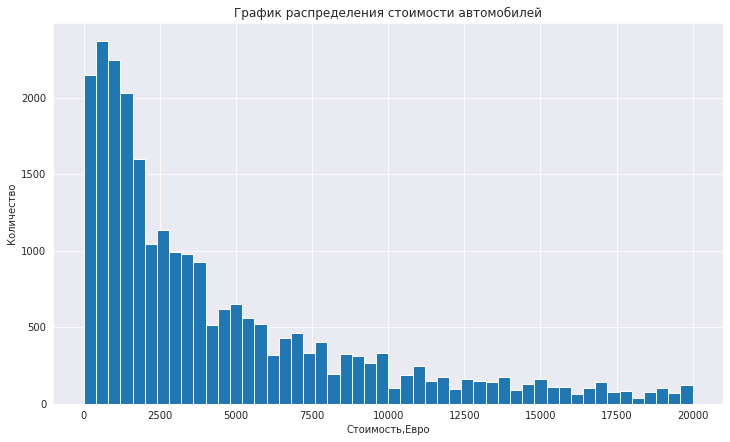

In [ ]:
sns.set_style('darkgrid')
data.Price.hist(bins=50,figsize=(12,7))
plt.title('График распределения стоимости автомобилей')
plt.xlabel('Стоимость,Евро')
plt.ylabel('Количество')
plt.show()

Удалим данные стоимости автомобилей ниже 10€, т.к. такие значения нам не интересны. Владельцы а/м могут указывать такую цену только за разбитый а/м под восставновление, либо с расчётом на равноценный обмен.

In [ ]:
data.loc[data['Price'] < 10]['Price'].count()

866

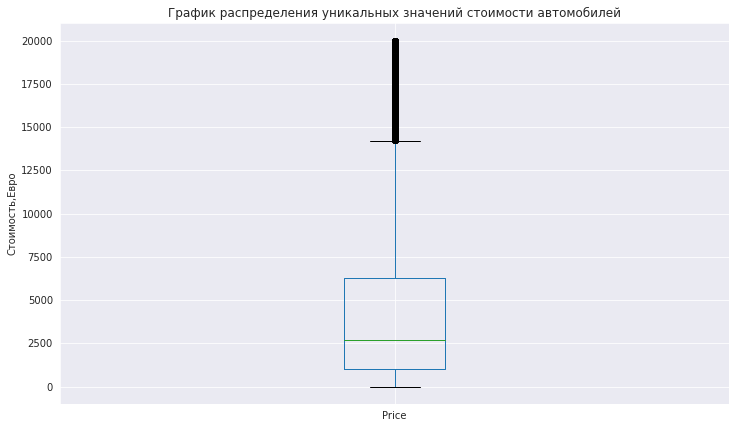

In [ ]:
data.boxplot(['Price'],figsize=(12,7))
plt.title('График распределения уникальных значений стоимости автомобилей')

plt.ylabel('Стоимость,Евро')
plt.show()

In [ ]:
data = data.query('Price> 10')

In [ ]:
data.loc[data['Price'] < 10]['Price'].count()

0

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23932 entries, 266750 to 234781
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   DateCrawled        23932 non-null  datetime64[ns]
 1   Price              23932 non-null  int64         
 2   VehicleType        21577 non-null  object        
 3   RegistrationYear   23932 non-null  int64         
 4   Gearbox            22724 non-null  object        
 5   Power              23932 non-null  int64         
 6   Model              22712 non-null  object        
 7   Kilometer          23932 non-null  int64         
 8   RegistrationMonth  23932 non-null  int64         
 9   FuelType           21892 non-null  object        
 10  Brand              23932 non-null  object        
 11  Repaired           19358 non-null  object        
 12  DateCreated        23932 non-null  datetime64[ns]
 13  NumberOfPictures   23932 non-null  int64         
 14  

In [ ]:
data['VehicleType']=data['VehicleType'].fillna('N/A')

In [ ]:
data.VehicleType.isna().sum()

0

In [ ]:
data.RegistrationYear.unique()

array([2004, 1996, 1995, 1999, 2002, 2001, 2003, 2007, 1990, 2011, 2008,
       2017, 1998, 1994, 2010, 2005, 2000, 2013, 1991, 1997, 2009, 2014,
       2015, 2006, 2016, 1989, 2018, 1986, 1985, 1970, 2012, 1992, 1976,
       1984, 1975, 1993, 1988, 1974, 1987, 1961, 1973, 1968, 1982, 1983,
       1980, 1978, 1971, 1964, 1959, 1972, 1966, 1800, 1969, 1977, 1979,
       1400, 1981, 1953, 1958, 5911, 5000, 6000, 1960, 1956, 1967, 1910,
       1957, 1962, 1951, 2019, 1929, 1600, 1963, 1965, 1000, 1942, 1955,
       1941, 1943, 1950, 1933])

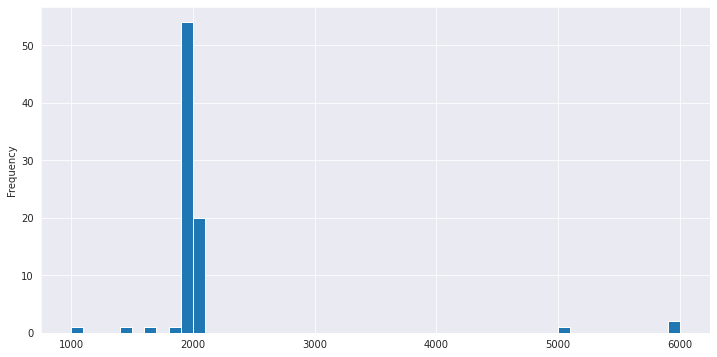

In [ ]:
pd.Series(list(data.RegistrationYear.unique())).sort_values(ascending=False).plot(kind='hist', figsize=(12,6), grid=True, bins=50)
plt.show()

Вычислим дату формирования списков а/м и отсортируем данные о регистрации по этой дате, а так же удалим совсем старые а/м, которым более 67 лет.

In [ ]:
data.DateCrawled.max()

Timestamp('2016-04-07 13:36:22')

In [ ]:
data=data.query('RegistrationYear >= 1970 & RegistrationYear < 2017')

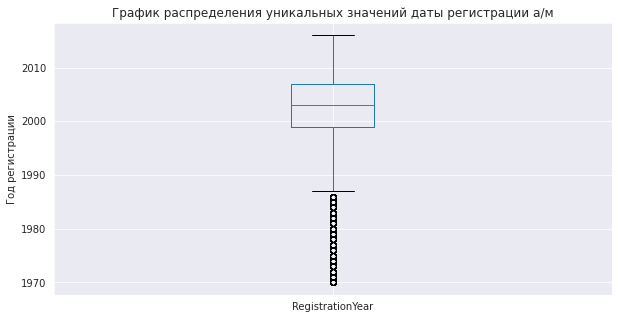

In [ ]:
data.boxplot('RegistrationYear', figsize=(10,5))
plt.title('График распределения уникальных значений даты регистрации а/м')
plt.ylabel('Год регистрации')
plt.xlabel('')
plt.show()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22899 entries, 266750 to 234781
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   DateCrawled        22899 non-null  datetime64[ns]
 1   Price              22899 non-null  int64         
 2   VehicleType        22899 non-null  object        
 3   RegistrationYear   22899 non-null  int64         
 4   Gearbox            21844 non-null  object        
 5   Power              22899 non-null  int64         
 6   Model              21841 non-null  object        
 7   Kilometer          22899 non-null  int64         
 8   RegistrationMonth  22899 non-null  int64         
 9   FuelType           21253 non-null  object        
 10  Brand              22899 non-null  object        
 11  Repaired           18787 non-null  object        
 12  DateCreated        22899 non-null  datetime64[ns]
 13  NumberOfPictures   22899 non-null  int64         
 14  

In [ ]:
data.query('Gearbox.isna()')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
140451,2016-03-08 17:45:30,1990,small,2002,NaN,41,fortwo,150000,2,gasoline,smart,no,2016-03-08,0,21107,2016-04-07 06:46:02
167818,2016-04-03 14:49:24,800,other,1997,NaN,0,agila,20000,0,petrol,opel,NaN,2016-04-03,0,65191,2016-04-06 21:45:13
106959,2016-03-12 09:59:13,2400,sedan,2004,NaN,0,a3,150000,8,gasoline,audi,NaN,2016-03-12,0,51065,2016-03-12 09:59:13
111022,2016-03-11 19:59:33,4900,bus,2004,NaN,0,x_reihe,150000,9,gasoline,bmw,NaN,2016-03-11,0,51065,2016-03-11 19:59:33
90052,2016-04-03 21:43:34,550,N/A,1985,NaN,0,golf,150000,10,NaN,volkswagen,NaN,2016-04-03,0,94447,2016-04-05 22:18:46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318090,2016-04-04 17:54:11,1700,wagon,2002,NaN,0,mondeo,150000,8,gasoline,ford,yes,2016-04-04,0,53123,2016-04-06 19:48:28
114079,2016-03-19 15:45:32,50,small,1996,NaN,50,other,150000,2,NaN,daihatsu,no,2016-03-19,0,86462,2016-04-01 03:15:47
102563,2016-03-28 15:25:41,6950,sedan,2000,NaN,143,c_klasse,80000,8,gasoline,mercedes_benz,no,2016-03-28,0,35584,2016-04-06 23:46:14
263860,2016-03-14 17:37:41,750,N/A,2000,NaN,0,NaN,150000,0,NaN,volkswagen,NaN,2016-03-14,0,50667,2016-04-06 00:15:41


Информация о корбкe передач достаточно важный параметр, который сильно может повлиять на модель при обучении. В связи с этим лучше избавиться от этих данных во избежании лишнего "шума", чем заполнить пропуски каким-то значением. К тому же по данным строкам есть множество ошибочных значений и пропусков в других столбцах

In [ ]:
data.dropna(subset=['Gearbox'], inplace=True)

In [ ]:
data.Gearbox.unique()

array(['auto', 'manual'], dtype=object)

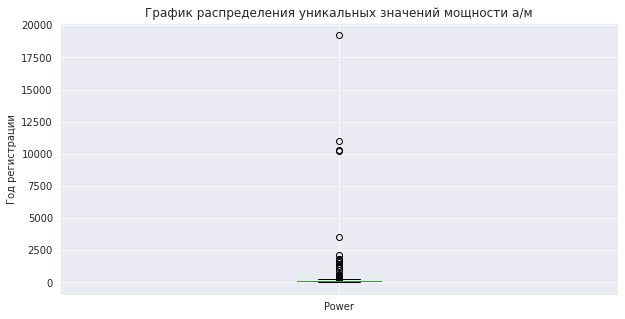

In [ ]:
data.boxplot('Power', figsize=(10,5))
plt.title('График распределения уникальных значений мощности а/м')
plt.ylabel('Год регистрации')
plt.xlabel('')
plt.show()

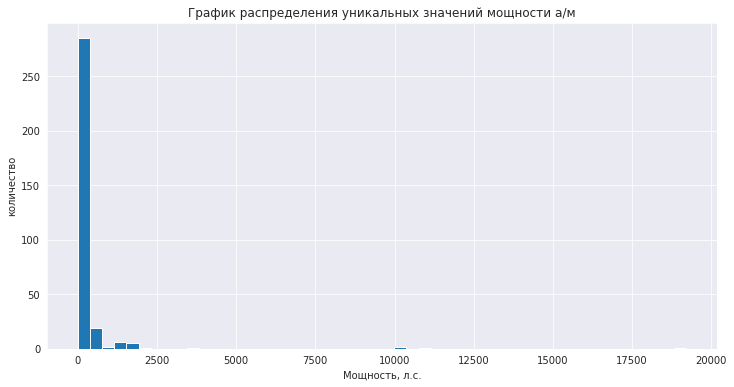

In [ ]:
pd.Series(list(data.Power.unique())).sort_values(ascending=False).plot(kind='hist', figsize=(12,6), grid=True, bins=50)
plt.title('График распределения уникальных значений мощности а/м')
plt.ylabel('количество')
plt.xlabel('Мощность, л.с.')
plt.show()

In [ ]:
data.Power.describe()

count    21844.000000
mean       115.088308
std        192.312749
min          0.000000
25%         75.000000
50%        105.000000
75%        143.000000
max      19211.000000
Name: Power, dtype: float64

Удалим данные о мощности дигателя свыше 2500 л.с. и менее 15 л.с.

In [ ]:
data=data.query('Power > 40 & Power < 600')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20134 entries, 138295 to 234781
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   DateCrawled        20134 non-null  datetime64[ns]
 1   Price              20134 non-null  int64         
 2   VehicleType        20134 non-null  object        
 3   RegistrationYear   20134 non-null  int64         
 4   Gearbox            20134 non-null  object        
 5   Power              20134 non-null  int64         
 6   Model              19443 non-null  object        
 7   Kilometer          20134 non-null  int64         
 8   RegistrationMonth  20134 non-null  int64         
 9   FuelType           19154 non-null  object        
 10  Brand              20134 non-null  object        
 11  Repaired           17362 non-null  object        
 12  DateCreated        20134 non-null  datetime64[ns]
 13  NumberOfPictures   20134 non-null  int64         
 14  

In [ ]:
data.query('Model.isna()')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
146523,2016-03-17 17:38:41,2000,sedan,1990,manual,120,NaN,150000,4,NaN,ford,NaN,2016-03-17,0,24226,2016-04-05 00:18:09
318262,2016-03-06 19:43:08,7500,bus,2001,auto,189,NaN,150000,1,petrol,sonstige_autos,no,2016-03-06,0,30952,2016-03-09 15:20:29
264610,2016-03-22 19:58:36,600,small,1994,manual,60,NaN,150000,9,petrol,opel,no,2016-03-22,0,25795,2016-04-06 02:44:55
285123,2016-04-04 22:36:19,330,small,1996,manual,60,NaN,150000,8,petrol,ford,no,2016-04-04,0,89191,2016-04-07 03:17:10
250311,2016-04-03 13:46:56,8299,suv,2004,auto,241,NaN,150000,9,petrol,sonstige_autos,no,2016-04-03,0,24539,2016-04-05 12:45:06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109348,2016-04-04 16:43:31,1600,small,1998,manual,75,NaN,150000,6,petrol,volkswagen,NaN,2016-04-04,0,26607,2016-04-06 18:17:06
257833,2016-03-11 20:47:50,1700,sedan,2001,manual,90,NaN,60000,0,NaN,renault,no,2016-03-11,0,47119,2016-04-06 04:17:13
51673,2016-03-15 19:36:19,1650,sedan,2003,manual,150,NaN,150000,0,gasoline,bmw,yes,2016-03-15,0,32312,2016-04-06 07:15:37
318053,2016-04-02 10:59:12,1500,wagon,2007,manual,139,NaN,150000,1,petrol,kia,no,2016-04-02,0,12043,2016-04-02 10:59:12


Модель - это основопологающий фактор, который на прямую воздействует на образование цены и заменить его на что-либо другое будет неправильно, удалим отсутствующие значения из наших данных

In [ ]:
data.dropna(subset=['Model'], inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19443 entries, 138295 to 234781
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   DateCrawled        19443 non-null  datetime64[ns]
 1   Price              19443 non-null  int64         
 2   VehicleType        19443 non-null  object        
 3   RegistrationYear   19443 non-null  int64         
 4   Gearbox            19443 non-null  object        
 5   Power              19443 non-null  int64         
 6   Model              19443 non-null  object        
 7   Kilometer          19443 non-null  int64         
 8   RegistrationMonth  19443 non-null  int64         
 9   FuelType           18606 non-null  object        
 10  Brand              19443 non-null  object        
 11  Repaired           16878 non-null  object        
 12  DateCreated        19443 non-null  datetime64[ns]
 13  NumberOfPictures   19443 non-null  int64         
 14  

In [ ]:
data.Kilometer.describe()

count     19443.000000
mean     128737.334773
std       36204.103977
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

Данный столбец не требует изменений, здесь всё Ок.

In [ ]:
data.RegistrationMonth.describe()

count    19443.000000
mean         6.080029
std          3.567630
min          0.000000
25%          3.000000
50%          6.000000
75%          9.000000
max         12.000000
Name: RegistrationMonth, dtype: float64

In [ ]:
data.RegistrationMonth.unique()

array([ 6,  9,  5, 11,  7,  2,  3, 10,  4,  1,  0,  8, 12])

In [ ]:
data.RegistrationMonth.value_counts()

3     2000
6     1812
4     1731
5     1617
7     1609
10    1530
12    1459
11    1427
9     1355
1     1322
8     1314
2     1268
0      999
Name: RegistrationMonth, dtype: int64

In [ ]:
data = data.drop('RegistrationMonth', axis=1)
#data.loc[data['RegistrationMonth'] == 0,'RegistrationMonth'] =6

In [ ]:
#data.loc[data['RegistrationMonth'] == 6].head()

In [ ]:

#data.RegistrationMonth.unique()

In [ ]:
data.FuelType.unique()

array(['petrol', 'gasoline', nan, 'lpg', 'hybrid', 'electric', 'cng',
       'other'], dtype=object)

In [ ]:
data.FuelType.value_counts()

petrol      12414
gasoline     5866
lpg           273
cng            37
hybrid         11
electric        3
other           2
Name: FuelType, dtype: int64

In [ ]:
data.FuelType.isna().sum()

837

Заполним отсутствующие значения как "other"

In [ ]:
data['FuelType']=data['FuelType'].fillna('other')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19443 entries, 138295 to 234781
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DateCrawled       19443 non-null  datetime64[ns]
 1   Price             19443 non-null  int64         
 2   VehicleType       19443 non-null  object        
 3   RegistrationYear  19443 non-null  int64         
 4   Gearbox           19443 non-null  object        
 5   Power             19443 non-null  int64         
 6   Model             19443 non-null  object        
 7   Kilometer         19443 non-null  int64         
 8   FuelType          19443 non-null  object        
 9   Brand             19443 non-null  object        
 10  Repaired          16878 non-null  object        
 11  DateCreated       19443 non-null  datetime64[ns]
 12  NumberOfPictures  19443 non-null  int64         
 13  PostalCode        19443 non-null  int64         
 14  LastSeen        

In [ ]:
data.Brand.unique()

array(['citroen', 'volkswagen', 'mitsubishi', 'fiat', 'opel', 'audi',
       'ford', 'hyundai', 'bmw', 'daihatsu', 'seat', 'mercedes_benz',
       'peugeot', 'smart', 'renault', 'skoda', 'mazda', 'subaru',
       'alfa_romeo', 'toyota', 'mini', 'nissan', 'honda', 'dacia', 'kia',
       'volvo', 'chrysler', 'suzuki', 'chevrolet', 'lancia', 'lada',
       'porsche', 'jeep', 'daewoo', 'land_rover', 'jaguar', 'rover',
       'saab', 'trabant'], dtype=object)

Отлично, здесь ничего дополнять или удалять не требуется

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19443 entries, 138295 to 234781
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DateCrawled       19443 non-null  datetime64[ns]
 1   Price             19443 non-null  int64         
 2   VehicleType       19443 non-null  object        
 3   RegistrationYear  19443 non-null  int64         
 4   Gearbox           19443 non-null  object        
 5   Power             19443 non-null  int64         
 6   Model             19443 non-null  object        
 7   Kilometer         19443 non-null  int64         
 8   FuelType          19443 non-null  object        
 9   Brand             19443 non-null  object        
 10  Repaired          16878 non-null  object        
 11  DateCreated       19443 non-null  datetime64[ns]
 12  NumberOfPictures  19443 non-null  int64         
 13  PostalCode        19443 non-null  int64         
 14  LastSeen        

In [ ]:
data.Repaired.unique()

array(['no', 'yes', nan], dtype=object)

In [ ]:
data.Repaired.isna().sum()

2565

Очевидно, что эти данные лучше заполнить N/A, чем потерять 37000 строк остального массива данных

In [ ]:
data['Repaired']=data['Repaired'].fillna('N/A')

In [ ]:
data.Repaired.unique()

array(['no', 'yes', 'N/A'], dtype=object)

In [ ]:
data.DateCreated.describe()

count                   19443
unique                     59
top       2016-04-03 00:00:00
freq                      784
first     2016-01-10 00:00:00
last      2016-04-07 00:00:00
Name: DateCreated, dtype: object

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19443 entries, 138295 to 234781
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DateCrawled       19443 non-null  datetime64[ns]
 1   Price             19443 non-null  int64         
 2   VehicleType       19443 non-null  object        
 3   RegistrationYear  19443 non-null  int64         
 4   Gearbox           19443 non-null  object        
 5   Power             19443 non-null  int64         
 6   Model             19443 non-null  object        
 7   Kilometer         19443 non-null  int64         
 8   FuelType          19443 non-null  object        
 9   Brand             19443 non-null  object        
 10  Repaired          19443 non-null  object        
 11  DateCreated       19443 non-null  datetime64[ns]
 12  NumberOfPictures  19443 non-null  int64         
 13  PostalCode        19443 non-null  int64         
 14  LastSeen        

In [ ]:
data.NumberOfPictures.describe()

count    19443.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: NumberOfPictures, dtype: float64

In [ ]:
data=data.drop(['NumberOfPictures'], axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19443 entries, 138295 to 234781
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DateCrawled       19443 non-null  datetime64[ns]
 1   Price             19443 non-null  int64         
 2   VehicleType       19443 non-null  object        
 3   RegistrationYear  19443 non-null  int64         
 4   Gearbox           19443 non-null  object        
 5   Power             19443 non-null  int64         
 6   Model             19443 non-null  object        
 7   Kilometer         19443 non-null  int64         
 8   FuelType          19443 non-null  object        
 9   Brand             19443 non-null  object        
 10  Repaired          19443 non-null  object        
 11  DateCreated       19443 non-null  datetime64[ns]
 12  PostalCode        19443 non-null  int64         
 13  LastSeen          19443 non-null  datetime64[ns]
dtypes: datetime64[ns

In [ ]:
data.PostalCode.describe()

count    19443.000000
mean     51627.716968
std      25811.624483
min       1067.000000
25%      31241.000000
50%      50825.000000
75%      72336.000000
max      99998.000000
Name: PostalCode, dtype: float64

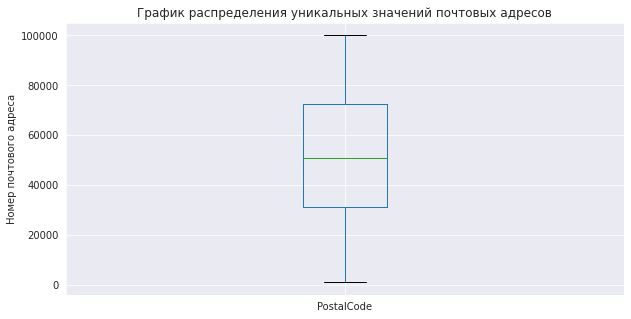

In [ ]:
data.boxplot('PostalCode', figsize=(10,5))
plt.title('График распределения уникальных значений почтовых адресов')
plt.ylabel('Номер почтового адреса')
plt.xlabel('')
plt.show()

Судя по графику нам эти данные не нужны и мы можем от них избавиться, они никак на цену не влияют.

In [ ]:
data = data.drop('PostalCode', axis=1)
#data["PostalCode"]=data["PostalCode"].astype('str')
#data.info()

In [ ]:
## first_index = []
#for word in np.array(data['PostalCode']):
#    case_word = word[0]
#    first_index.append(case_word)
#data["GeogrphyIndex"]=first_index
#data["GeogrphyIndex"]=data["GeogrphyIndex"].astype('int')

In [ ]:
data.head(2)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,LastSeen
138295,2016-03-10 00:57:47,500,wagon,1996,manual,120,other,150000,petrol,citroen,no,2016-03-09,2016-04-06 00:46:43
164313,2016-03-16 19:42:07,750,small,1995,manual,75,polo,150000,petrol,volkswagen,no,2016-03-16,2016-03-19 18:15:17


In [ ]:
data.LastSeen.describe()

count                   19443
unique                  17445
top       2016-04-05 16:45:06
freq                        5
first     2016-03-05 14:35:28
last      2016-04-07 14:58:50
Name: LastSeen, dtype: object

In [ ]:
data\
    .corr()\
    .style\
    .background_gradient(cmap='coolwarm')

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.550286,0.508526,-0.403451
RegistrationYear,0.550286,1.000000,0.134254,-0.362984
Power,0.508526,0.134254,1.000000,0.093515
Kilometer,-0.403451,-0.362984,0.093515,1.000000


Наблюдается сильная положительная корреляция стоимости от мощности и года регитстрации а/м, в то время как пробег имеет сильную отрицательную зависмость и так же сказывается на ценообразовании подержанного автомобиля

# Вывод по предобработке данных

Была изучена таблица данных.

Выведены аномальные и пропущенные значения.

Отобраны небходимые столбцы для обучения модели.

Заполнены пропуски в столбцах и удалены некорректные значения.

Заменены два категориальных признака на численные.

# Просмотим зависимотсть целевого значения от других признаков в наших данных на гарфике

In [ ]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired',
       'DateCreated', 'LastSeen'],
      dtype='object')

In [ ]:
column=['Price', 'RegistrationYear',
       'Power', 'Kilometer','FuelType']

In [ ]:
data_graph=data[column]
data_graph[:5]

,Price,RegistrationYear,Power,Kilometer,FuelType
138295,500,1996,120,150000,petrol
164313,750,1995,75,150000,petrol
290384,350,1999,75,90000,petrol
28358,1500,2001,65,80000,petrol
217796,800,2003,101,150000,petrol


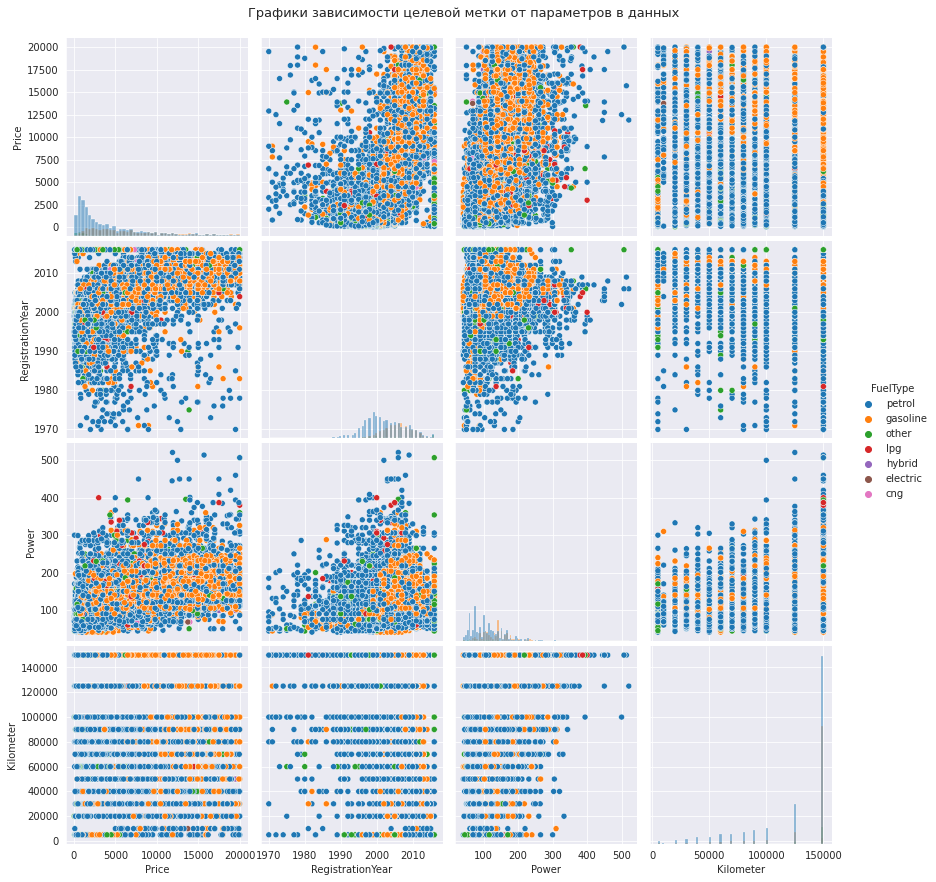

In [ ]:
sns.pairplot(data_graph[:100000], hue='FuelType', height=3, diag_kind='hist')
plt.suptitle("Графики зависимости целевой метки от параметров в данных", y=1.02, fontsize=13)
plt.show()

Судя по графику можно сказать, что начиная с 1980 года стоимосоть а/м увеличивается с каждым годом и имеет линейную зависимость, при этом не важен тип используемого топлива. Так же из графиков хорошо видно, что альтернативные виды топлива начали активно использоваться в автомобилях начиная с 2000 годов в то время как бензиновые двигателя начали отходить на второй план

# Применим кодирование текстовых данных в категориальные цифровые значения методом OrdinalEncoder

Для начала выберем действительно значимые столбцы, которые могут иметьзначения в ценообразовании стоимости подержанных автомоблилей, а лишние значения мы опустим, чтобы не "зашумлять" вычисления моделей

In [ ]:
data.head(2)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,DateCreated,LastSeen
138295,2016-03-10 00:57:47,500,wagon,1996,manual,120,other,150000,petrol,citroen,no,2016-03-09,2016-04-06 00:46:43
164313,2016-03-16 19:42:07,750,small,1995,manual,75,polo,150000,petrol,volkswagen,no,2016-03-16,2016-03-19 18:15:17


In [ ]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'FuelType', 'Brand', 'Repaired',
       'DateCreated', 'LastSeen'],
      dtype='object')

In [ ]:
columns=['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'FuelType', 'Brand',
       'Repaired']

Запишем данные с интересующими нас столбцами в новый Data Frame

In [ ]:
data.duplicated().sum()

0

In [ ]:
duplicates = data[data.duplicated(keep=False)]  # keep=False отмечает все копии
duplicates_sorted = duplicates.sort_values(by=data.columns.tolist())
print(duplicates_sorted)
data = data.drop_duplicates(keep='first')

Empty DataFrame
Columns: [DateCrawled, Price, VehicleType, RegistrationYear, Gearbox, Power, Model, Kilometer, FuelType, Brand, Repaired, DateCreated, LastSeen]
Index: []


In [ ]:
data_for_model = data[columns].copy()
data_for_model.head(2)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
138295,500,wagon,1996,manual,120,other,150000,petrol,citroen,no
164313,750,small,1995,manual,75,polo,150000,petrol,volkswagen,no


In [ ]:
data.duplicated().sum()

0

In [ ]:
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19443 entries, 138295 to 234781
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Price             19443 non-null  int64 
 1   VehicleType       19443 non-null  object
 2   RegistrationYear  19443 non-null  int64 
 3   Gearbox           19443 non-null  object
 4   Power             19443 non-null  int64 
 5   Model             19443 non-null  object
 6   Kilometer         19443 non-null  int64 
 7   FuelType          19443 non-null  object
 8   Brand             19443 non-null  object
 9   Repaired          19443 non-null  object
dtypes: int64(4), object(6)
memory usage: 1.6+ MB


Сбросим индексы, после удаления лишних значений

In [ ]:
data_for_model=data_for_model.reset_index(drop=True)

In [ ]:
data_for_model

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,500,wagon,1996,manual,120,other,150000,petrol,citroen,no
1,750,small,1995,manual,75,polo,150000,petrol,volkswagen,no
2,350,coupe,1999,manual,75,colt,90000,petrol,mitsubishi,yes
3,1500,bus,2001,manual,65,doblo,80000,petrol,fiat,no
4,800,wagon,2003,auto,101,astra,150000,petrol,opel,no
...,...,...,...,...,...,...,...,...,...,...
19438,1000,small,1990,manual,103,fiesta,150000,petrol,ford,no
19439,1150,small,2002,manual,58,clio,150000,petrol,renault,no
19440,9799,suv,2011,manual,105,duster,70000,petrol,dacia,no
19441,3500,small,2006,manual,75,ibiza,150000,petrol,seat,no


In [ ]:
#duplicates = data_for_model[data_for_model.duplicated(keep=False)]  # keep=False отмечает все копии
#duplicates_sorted = duplicates.sort_values(by=data_for_model.columns.tolist())
#print(duplicates_sorted)
#data_for_model = data_for_model.drop_duplicates(keep='first')

In [ ]:
# код ревьюера
data_for_model.duplicated().sum()

317

In [ ]:
data_for_model.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [ ]:
data_for_model = data_for_model.drop_duplicates(keep=False)

In [ ]:
data_for_model.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [ ]:
data_for_model.duplicated().sum()

0

<div class="alert alert-info">
Я не понимаю в чём проблема если я не удаляю дубликаты то всё хорошо а если удаляю у меня код не выполняется
</div>

# Разделим данные на основную выборку и целевые признаки

In [ ]:
features=data_for_model.drop(['Price'],axis=1)
target=data_for_model['Price']

In [ ]:
features.columns

Index(['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

In [ ]:
features.head(1)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,wagon,1996,manual,120,other,150000,petrol,citroen,no


Выберем только категориальные признаки

In [ ]:
col=['VehicleType', 'Gearbox','Model',
       'FuelType', 'Brand', 'Repaired']

In [ ]:
encoder = OrdinalEncoder()
encoder.fit(features[col])
features_ord=features.copy()
features_ord[col] = pd.DataFrame(
    encoder.transform(features[col]),
    columns=features[col].columns,
    index=features.index
)

In [ ]:
train_features, test_features, train_target, test_target = train_test_split(features_ord,target, test_size=0.25, random_state=254)


In [ ]:
print("NaN в features:", np.isnan(train_features).sum())


NaN в features: VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64


In [ ]:
train_features = train_features.fillna(train_features.mean())
test_features = test_features.fillna(train_features.mean())

<div class="alert alert-info">
Если заполняю медианными значениями то всё работает но я не понимаю откуда берутся пропуски в значениях
</div>

In [ ]:
# nan_rows = train_features[train_features.isna().any(axis=1)]
#display(nan_rows)

In [ ]:
train_sample=train_features.shape[0]/features.shape[0]
test_sample=test_target.shape[0]/target.shape[0]

print('Размер тренировочной выборки- {:.0%}'.format(train_sample))
print('Размер тестовой выборки - {:.0%}'.format(test_sample))

Размер тренировочной выборки- 75%
Размер тестовой выборки - 25%


# Применим масштабирование к нашим данным при помощи StandardScaler

In [ ]:
numeric=['VehicleType','RegistrationYear','Gearbox','Power','Model','Kilometer','FuelType','Brand','Repaired']
scaler=StandardScaler()
scaler.fit(features_ord[numeric])


train_features[numeric]=scaler.transform(train_features[numeric])
test_features[numeric]=scaler.transform(test_features[numeric])


print(train_features.shape)
print(test_features.shape)

train_features.head()

(14123, 9)
(4708, 9)


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
18457,1.270221,1.133342,0.503383,0.017615,0.786227,-0.099659,0.707627,0.816016,0.070559
10813,-0.902701,-0.171518,-1.986558,2.101992,-1.387357,0.589685,0.707627,-1.409408,-2.008787
6545,0.401052,0.154697,0.503383,-0.881153,-0.345228,-0.099659,0.707627,0.278845,0.070559
19380,-0.033533,-0.987055,0.503383,0.973751,-1.387357,0.589685,0.707627,-1.409408,0.070559
11228,-1.771870,0.807127,0.503383,-0.364840,1.560381,-0.099659,0.707627,1.276449,0.070559


Вывод

Отлично, из даных убраны лишние и "битые" значения, текстовые признаки трансформированы в цифровой формат, а так же выборки разделены на тренировочную и тестовую для проверки качества предсказания моделей. Теперь перейдём к обучению моделей и выбору лучшей. А так же оценим их качество предсказания и скорость обучения.

## Обучение моделей

Обучим разные модели. Для каждой укажем оптимальные гиперпараметры и поставим счётчик времени выполнения операций.

Для расчёта целевой метрики используем RMSE и напишем функцию.

In [ ]:
def rmse(test,predict):
    return ((mean_squared_error(test,predict))**0.5).round(2)

Создадим функцию, которая будет принимать на вход целевые и предсказанные значения, а возвращать абсолютное и среднеквадратичное отклонение на графиках с визульным распределением разброса целевых признаков

In [ ]:
def illustration_target(test,predict):
    rmse= mean_squared_error(test,predict)
    mae=mean_absolute_error(test,predict)
    plt.figure(figsize=(8, 5))
    pd.Series(predict).hist(bins=20, alpha=0.8)
    pd.Series(test).hist(bins=20, alpha=0.8)
    plt.text(16122,11225,'MAE={:.2f}'.format(mae))
    plt.text(16122,10225,'RMSE={:.2f}'.format(rmse**0.5))
    plt.legend(['Предсказанные значения', 'Истинные значения'])
    plt.title('График распределения предсказанных и истинных значениий', y=1.05)
    plt.xlabel('Предсказанные / Истинные значения')
    plt.ylabel('Количество')
    plt.subplot()

    plt.figure(figsize=(8, 8))
    plt.plot(predict,test,'o', alpha=0.5)
    plt.xlim(-5000,25000)
    plt.ylim(-5000,25000)
    plt.plot([-10000,25000],[-10000,25000],'--y', linewidth=2)
    #plt.text(25222,11225,'MAE={:.2f}'.format(mae))
    #plt.text(25222,10225,'RMSE={:.2f}'.format(rmse**0.5))
    plt.title('График отношения предсказанных значений к истинным значениям', y=1.05)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.show()

Для понимания, какие факторы важны при моделировании, создадим функцию, используя

feature_importances_

In [ ]:
def importances(model,features):
    features=features.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(11, 5))
    plt.title('Важность функции')
    plt.barh(range(len(indices)), importances[indices], color='#6495ED', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Относительная важность')
    plt.show()

    feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)
    feat_importances = feat_importances.to_frame()
    feat_importances.columns=['Относительная важность']
    display(feat_importances)

# LinearRegression

In [ ]:
model_lr = LinearRegression()

# Замер времени обучения
start_train = time.time()
model_lr.fit(train_features, train_target)
time1 = time.time() - start_train

# 3. Кросс-валидация с замером времени
start_cv = time.time()
cv_predictions = cross_val_predict(
    model_lr,
    train_features,
    train_target,
    cv=5
)
cv_time = time.time() - start_cv

print(f"Время обучения модели: {time1:.2f} сек")
print(f"Время кросс-валидации (5 фолдов): {cv_time:.2f} сек")


Время обучения модели: 0.01 сек
Время кросс-валидации (5 фолдов): 0.31 сек


In [ ]:
print(' Гиперпараметры модели:\n',model_lr)

 Гиперпараметры модели:
 LinearRegression()


In [ ]:
#mae_lr=mean_absolute_error(test_target, predict_lr)
#print('MAE модели Линейная Регрессия равна:',mae_lr.round(2))
#rmse_lr=rmse(test_target, predict_lr)
#print('RMSE модели Линейная Регрессия равна:', rmse_lr)

Для линейной регрессии "важность признаков" можно оценить через коэффициенты, статистику или перестановочные методы, но стандартной feature_importance (как в деревьях) здесь нет.

# RandomForestRegressor

In [ ]:
model_rf = RandomForestRegressor(random_state=12345, criterion='mse',warm_start=False, n_estimators=100)

# Замер времени обучения
start_train = time.time()
model_rf.fit(train_features, train_target)
time2 = time.time() - start_train

# 3. Кросс-валидация с замером времени
start_cv = time.time()
cv_predictions = cross_val_predict(
    model_rf,
    train_features,
    train_target,
    cv=5
)
cv_time = time.time() - start_cv

print(f"Время обучения модели: {time2:.2f} сек")
print(f"Время кросс-валидации (5 фолдов): {cv_time:.2f} сек")






Время обучения модели: 3.17 сек
Время кросс-валидации (5 фолдов): 13.26 сек


Факторы важности модели RandomForestRegressor

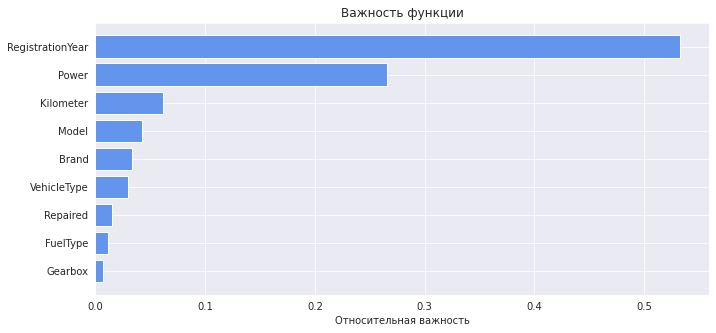

,Относительная важность
RegistrationYear,0.532953
Power,0.265938
Kilometer,0.061473
Model,0.042827
Brand,0.033700
VehicleType,0.029735
Repaired,0.015019
FuelType,0.011174
Gearbox,0.007181


In [ ]:
importances(model_rf,test_features)

# CatBoostRegressor

In [ ]:
model_cat = CatBoostRegressor(random_state=123,learning_rate=0.4, verbose=100,n_estimators=1000)
# Замер времени обучения
start_train = time.time()
model_cat.fit(train_features, train_target, eval_set=(test_features,test_target))
time3 = time.time() - start_train

# 3. Кросс-валидация с замером времени
start_cv = time.time()
cv_predictions = cross_val_predict(
    model_cat,
    train_features,
    train_target,
    cv=5
)
cv_time = time.time() - start_cv

print(f"Время обучения модели: {time3:.2f} сек")
print(f"Время кросс-валидации (5 фолдов): {cv_time:.2f} сек")






0:	learn: 3486.1004278	test: 3609.6445781	best: 3609.6445781 (0)	total: 50.8ms	remaining: 50.7s
100:	learn: 1436.3838495	test: 1808.9249403	best: 1808.9249403 (100)	total: 318ms	remaining: 2.83s
200:	learn: 1278.5708470	test: 1787.0191967	best: 1785.9032073 (190)	total: 569ms	remaining: 2.26s
300:	learn: 1187.7280359	test: 1788.0652104	best: 1781.9342749 (218)	total: 815ms	remaining: 1.89s
400:	learn: 1130.0659719	test: 1791.5067303	best: 1781.9342749 (218)	total: 1.06s	remaining: 1.59s
500:	learn: 1085.6093820	test: 1798.2604120	best: 1781.9342749 (218)	total: 1.33s	remaining: 1.32s
600:	learn: 1046.8734973	test: 1794.9629162	best: 1781.9342749 (218)	total: 1.57s	remaining: 1.04s
700:	learn: 1017.6917711	test: 1796.9064227	best: 1781.9342749 (218)	total: 1.82s	remaining: 776ms
800:	learn: 988.6748421	test: 1801.2773096	best: 1781.9342749 (218)	total: 2.07s	remaining: 514ms
900:	learn: 962.2327050	test: 1805.2489472	best: 1781.9342749 (218)	total: 2.31s	remaining: 254ms
999:	learn: 942

Факторы важности модели CatBoostRegressor

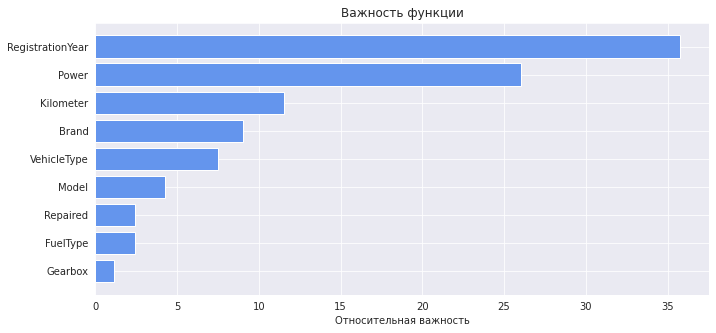

,Относительная важность
RegistrationYear,35.765275
Power,26.022302
Kilometer,11.510412
Brand,9.010562
VehicleType,7.484687
Model,4.267204
Repaired,2.409820
FuelType,2.404266
Gearbox,1.125471


In [ ]:
importances(model_cat,train_features)

# LightGBM

In [ ]:
model_lgb = lgbm.sklearn.LGBMRegressor(n_estimators=200, random_state=123, learning_rate=0.4, objective='rmse')
# Замер времени обучения
start_train = time.time()
model_lgb.fit(train_features, train_target, eval_set=(test_features,test_target), verbose=100)
time4 = time.time() - start_train

# 3. Кросс-валидация с замером времени
start_cv = time.time()
cv_predictions = cross_val_predict(
    model_lgb,
    train_features,
    train_target,
    cv=5
)
cv_time = time.time() - start_cv

print(f"Время обучения модели: {time4:.2f} сек")
print(f"Время кросс-валидации (5 фолдов): {cv_time:.2f} сек")




[100]	valid_0's rmse: 1819.12
[200]	valid_0's rmse: 1834.94
Время обучения модели: 2.13 сек
Время кросс-валидации (5 фолдов): 10.51 сек


Факторы важности модели LightGBM

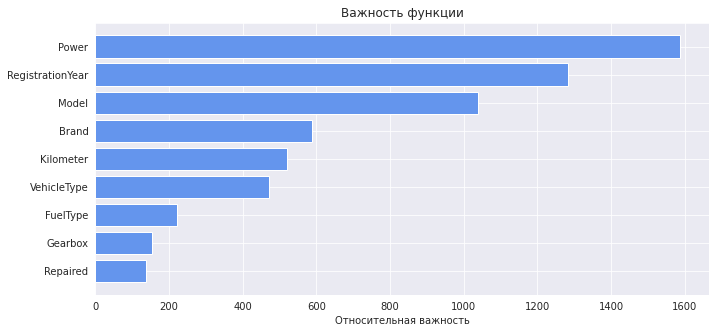

,Относительная важность
Power,1587
RegistrationYear,1283
Model,1039
Brand,588
Kilometer,521
VehicleType,470
FuelType,221
Gearbox,153
Repaired,138


In [ ]:
importances(model_lgb,train_features)

Вывод

По качеству предсказания на метрике MAE и распределению значений на графиках лучше всех себя показала модель RandomForestRegressor, в то время как модель LightGBM показала лучший результат по RMSE и в отличии от двух других моделей важность года регистрации (RegistrationYear) ушла на второй план уступив мощности (Power), а вот модель LinearRegression оказаласть совсем не точной, но за то быстрее всех.

## Анализ моделей


Время предсказания на тесте: 0.00 сек

Финальные метрики на тестовой выборке:
RMSE: 3055.78


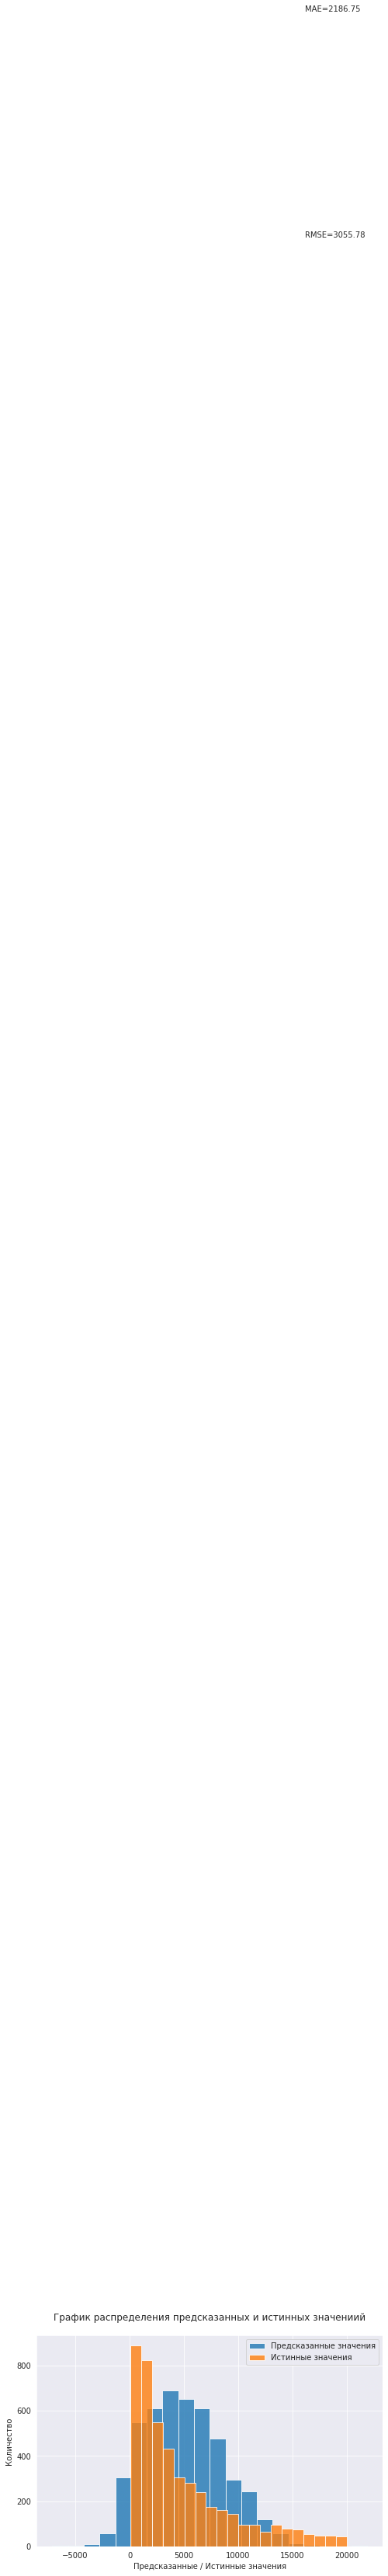

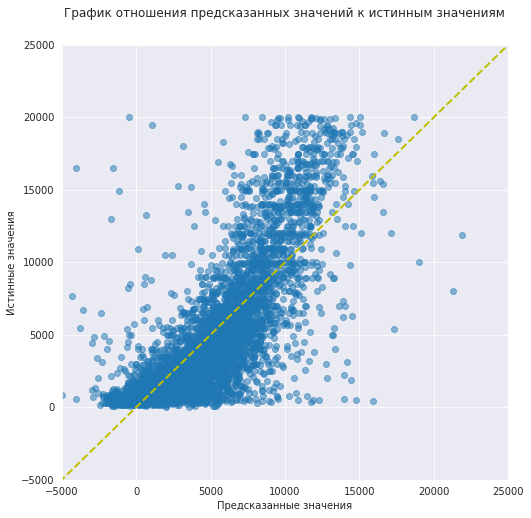

In [ ]:
start_test = time.time()
test_lr = model_lr.predict(test_features)
lr_time = time.time() - start_test

print(f"\nВремя предсказания на тесте: {lr_time:.2f} сек")
print("\nФинальные метрики на тестовой выборке:")
rmse_lr=rmse(test_target, test_lr)
print(f"RMSE: {rmse(test_target, test_lr)}")
illustration_target(test_target, test_lr)


Время предсказания на тесте: 0.14 сек

Финальные метрики на тестовой выборке:
RMSE: 1962.17


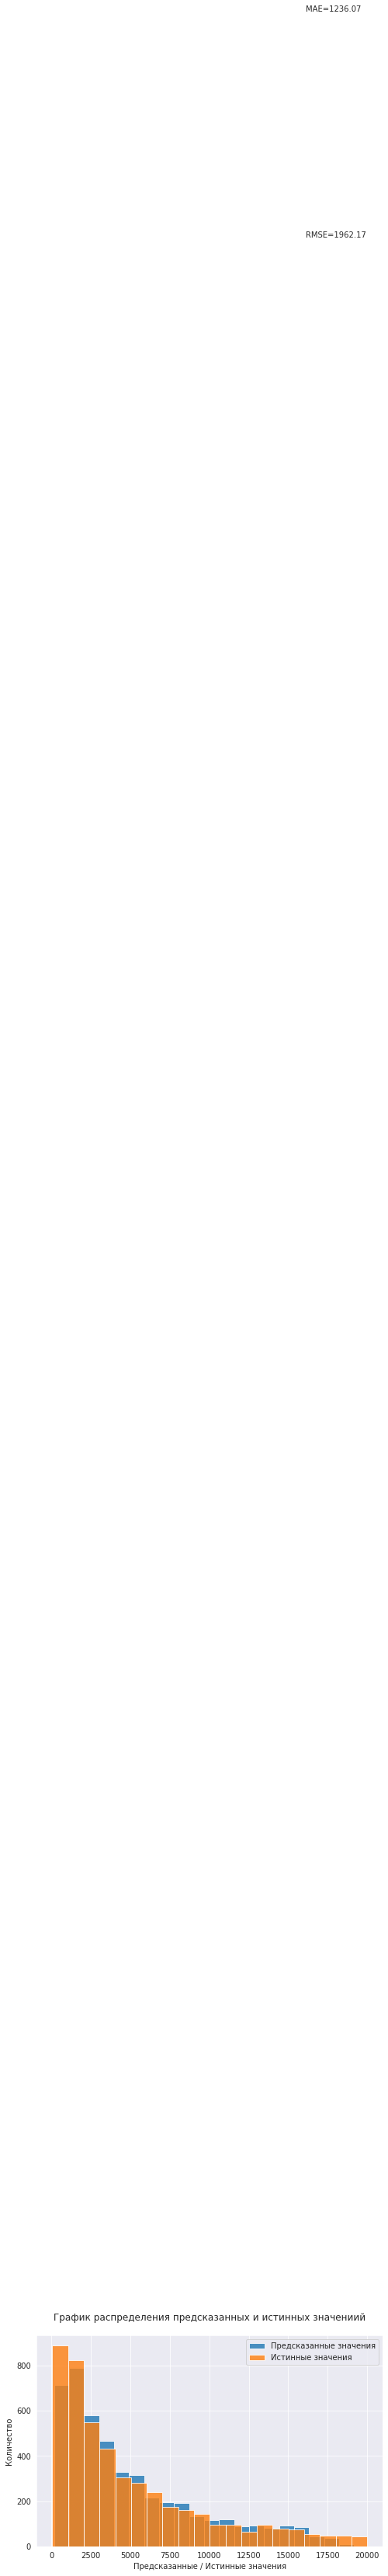

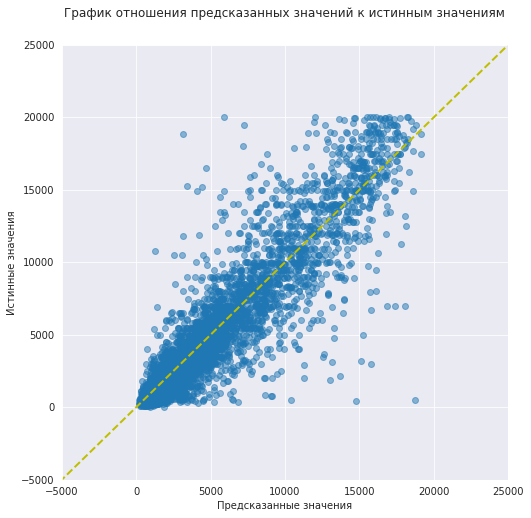

In [ ]:
start_test = time.time()
test_rf = model_rf.predict(test_features)
rf_time = time.time() - start_test

print(f"\nВремя предсказания на тесте: {rf_time:.2f} сек")
print("\nФинальные метрики на тестовой выборке:")
rmse_rf=rmse(test_target, test_rf)
print(f"RMSE: {rmse(test_target, test_rf)}")
illustration_target(test_target, test_rf)


Время предсказания на тесте: 0.00 сек

Финальные метрики на тестовой выборке:
RMSE: 1781.93


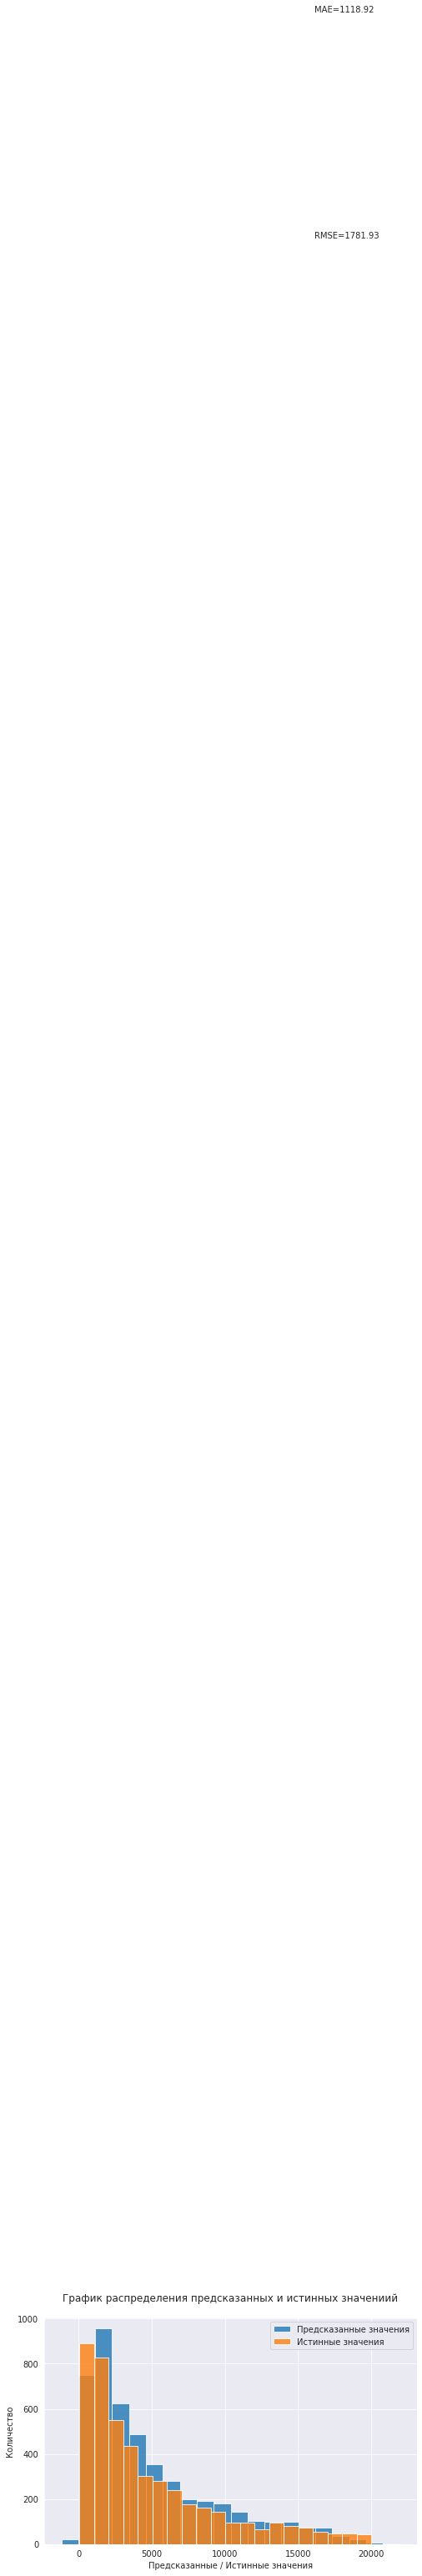

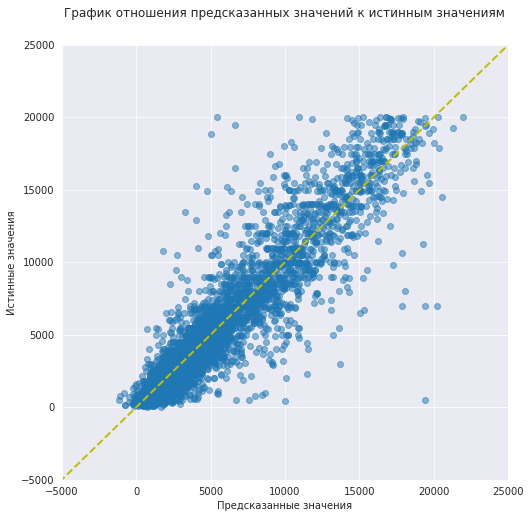

In [ ]:
start_test = time.time()
test_cat = model_cat.predict(test_features)
cat_time = time.time() - start_test

print(f"\nВремя предсказания на тесте: {cat_time:.2f} сек")
print("\nФинальные метрики на тестовой выборке:")
rmse_cat=rmse(test_target, test_cat)
print(f"RMSE: {rmse(test_target, test_cat)}")
illustration_target(test_target, test_cat)


Время предсказания на тесте: 0.01 сек

Финальные метрики на тестовой выборке:
RMSE: 1834.94


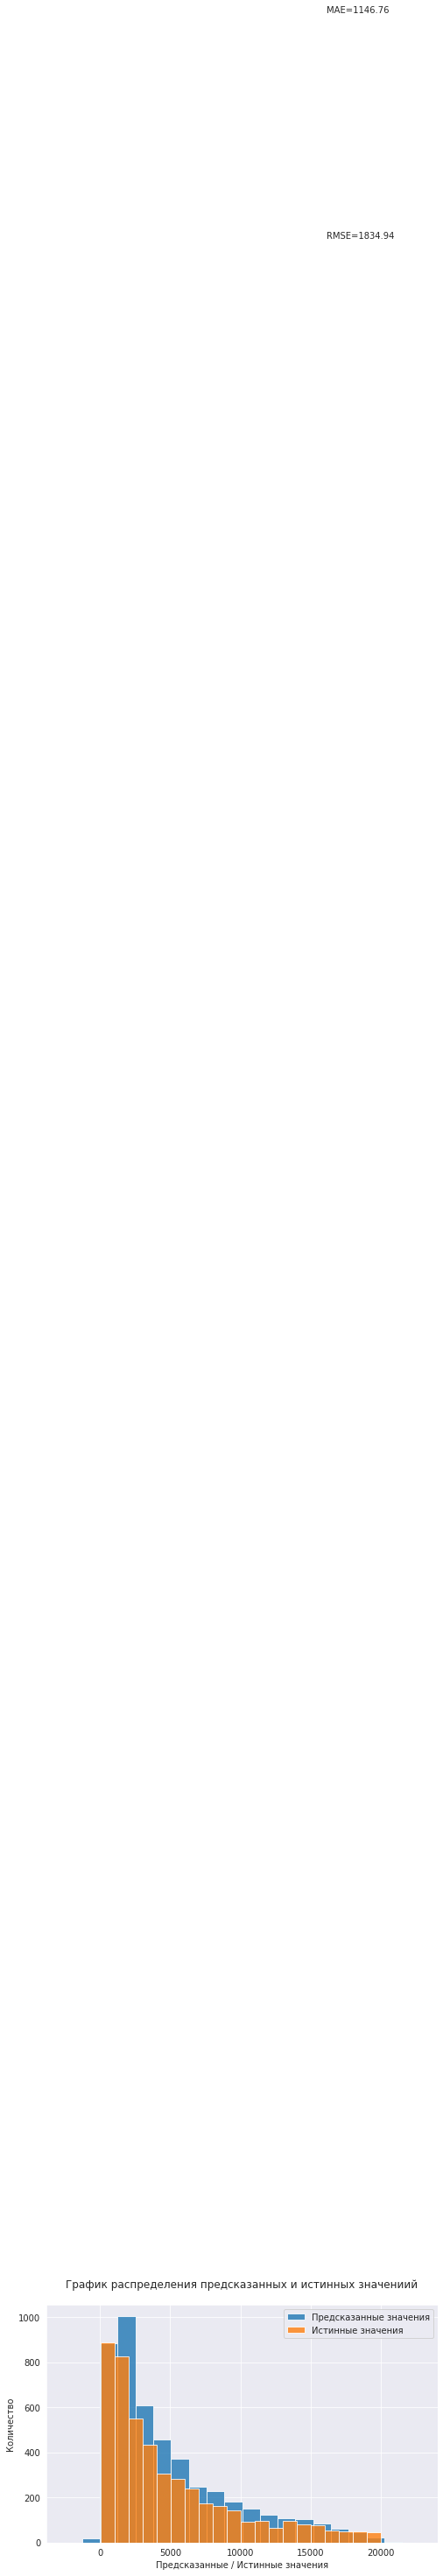

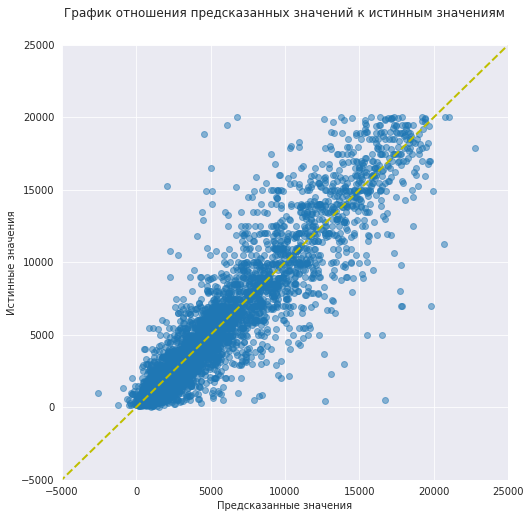

In [ ]:
start_test = time.time()
test_lgb = model_lgb.predict(test_features)
lgb_time = time.time() - start_test

print(f"\nВремя предсказания на тесте: {lgb_time:.2f} сек")
print("\nФинальные метрики на тестовой выборке:")
rmse_lgb=rmse(test_target, test_lgb)
print(f"RMSE: {rmse(test_target, test_lgb)}")
illustration_target(test_target, test_lgb)

Проанализируем скорость работы и качество моделей.

In [ ]:
column=['RMSE модели','Скорость обучения, s','Скорость предсказания, s']

comparison_tabl = pd.DataFrame(index=['RMSE модели','Скорость обучения, s', 'Скорость предсказания, s'], columns=['LinearRegression','RandomForestRegressor','CatBoostRegressor','LightGBM'])
comparison_tabl['LinearRegression'] = rmse_lr, lr_time, time1
comparison_tabl['RandomForestRegressor'] = rmse_rf, rf_time, time2
comparison_tabl['CatBoostRegressor'] = rmse_cat,  cat_time, time3
comparison_tabl['LightGBM'] = rmse_lgb, lgb_time,time4

comparison_tabl.T.style.highlight_min(color='yellowgreen',subset=column).highlight_null(null_color='lightgrey').highlight_max(color='coral',subset=column)

,RMSE модели,"Скорость обучения, s","Скорость предсказания, s"
LinearRegression,3055.780000,0.002517,0.005583
RandomForestRegressor,1962.170000,0.144514,3.173951
CatBoostRegressor,1781.930000,0.004688,3.991861
LightGBM,1834.940000,0.011675,2.127357


Проведём анализ остатков предсказаний моделей и определим что и как модель чаще всего хорошо/плохо предсказывает

Добавим в выборку категоризацию по типу возрастного класса а/м

In [ ]:
features1=features.copy()

Для дальнейшей фильтрации, посмотрим список присутствующих значений в нашей выборке по годам в порядке возростания

In [ ]:
pd.Series(features1['RegistrationYear'].unique()).sort_values(ascending=True)

33    1970
37    1971
45    1972
32    1973
41    1974
42    1975
25    1976
46    1977
44    1978
40    1979
43    1980
39    1981
34    1982
35    1983
26    1984
38    1985
36    1986
31    1987
28    1988
30    1989
29    1990
15    1991
23    1992
27    1993
10    1994
1     1995
0     1996
20    1997
9     1998
2     1999
13    2000
3     2001
6     2002
4     2003
22    2004
12    2005
19    2006
5     2007
8     2008
16    2009
11    2010
7     2011
24    2012
14    2013
17    2014
18    2015
21    2016
dtype: int64

Добавим категории в нашу выборку в зависимсоти от года авто ретро, суперретро, старая, новая

In [ ]:
k=[]
for i in features1['RegistrationYear']:
    if  i <= 2000:
        retro='Retro'
        k.append(retro)
    if i > 2000 and i <= 2012:
        old='Old'
        k.append(old)
    if i > 2012:
        new='New'
        k.append(new)
features['AgeType']=k

In [ ]:
features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,AgeType
0,wagon,1996,manual,120,other,150000,petrol,citroen,no,Retro
1,small,1995,manual,75,polo,150000,petrol,volkswagen,no,Retro
2,coupe,1999,manual,75,colt,90000,petrol,mitsubishi,yes,Retro
3,bus,2001,manual,65,doblo,80000,petrol,fiat,no,Old
4,wagon,2003,auto,101,astra,150000,petrol,opel,no,Old


Добавим разницу значений предсказания - истинные значения в таблицу для наших моделей

In [ ]:
test_features['AgeType']=features['AgeType'][test_features.index]

In [ ]:
test_features['Test_LGBM']=test_lgb-test_target
test_features['Test_CAT']=test_cat-test_target
test_features['Test_RandomForest']=test_rf-test_target
test_features['Test_LinRegressor']=test_lr-test_target
test_features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,AgeType,Test_LGBM,Test_CAT,Test_RandomForest,Test_LinRegressor
1619,1.270221,-1.313270,0.503383,-0.097122,-1.268257,0.589685,0.707627,-1.486147,0.070559,Retro,810.041763,747.702825,523.730000,147.757066
3491,0.401052,-0.660840,0.503383,-1.167994,-0.464328,-1.340478,0.707627,0.509061,2.149906,Retro,-110.553301,-352.538967,-155.614167,2210.239670
6801,0.401052,0.970234,-1.986558,-0.900276,1.902795,-3.408509,0.707627,1.122971,0.070559,Old,-2079.510529,-2087.252846,-2629.746667,1328.504681
4548,-2.206454,2.111986,0.503383,-0.632558,-1.402245,0.589685,0.707627,-0.104849,2.149906,New,-500.519855,-967.308359,-552.941667,3881.403740
3503,0.401052,-0.008410,0.503383,-1.206240,1.634819,-0.099659,0.707627,0.509061,0.070559,Old,388.773081,829.406284,666.959833,912.188890


Составим сводную таблицу по среднему значению отклонения предсказанных от истинных значений с разбивкой на типы возраста а/м

In [ ]:

analis_table=test_features.groupby('AgeType')[['Test_LGBM','Test_CAT','Test_RandomForest','Test_LinRegressor']].mean()
analis_table.columns=['LightGBM', 'CatBoostRegressor','RandomForestRegressor','LinearRegressor']
analis_table

,LightGBM,CatBoostRegressor,RandomForestRegressor,LinearRegressor
AgeType,,,,
New,230.215311,134.115891,331.197902,1296.738155
Old,-41.174471,-29.170589,-3.407087,-168.803889
Retro,39.521191,14.073177,83.164584,101.353996


Для наглядности отобразим отклонения на графике

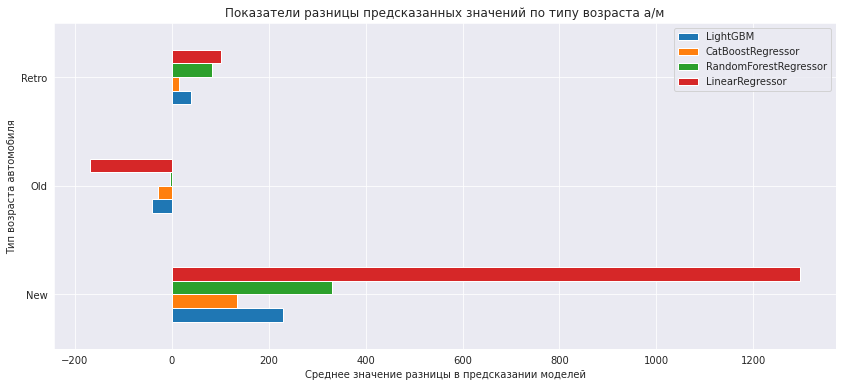

In [ ]:
analis_table.plot(kind='barh',align='center',figsize=(14,6))
plt.title('Показатели разницы предсказанных значений по типу возраста а/м')
plt.xlabel('Среднее значение разницы в предсказании моделей')
plt.ylabel('Тип возраста автомобиля')
plt.show()

Вывод

По результату анализа остатков предсказания моделей, на графике хорошо видно сильное отрицательное отклонение в предсказании данных при помощи LinearRegressor в возростной группе автомобилей SuperRetro. По другим моделям наблюдается некоторый паритет по обработке возрастных категорий.

## Общий вывод
Перед нами стояла задача- построить модель для определения стоимости автомобиля, с лушими показателями качества предсказания, скорости и врмени обучения. В нашем распоряжении были исторические данные: технические характеристики, комплектации и цены автомобилей.

Мы использовали технологию градиетного бустинга в моделях CatBoostRegressor и LightGBM, и сравнили её с базовыми моделями LinearRegression и RandomForestRegressor

По итогам качества и скорости обучения на тестовых данных - с небольшим отрывом от CatBoostRegressor побеждает модель LightGBM, но сильно уступает по скорости предсказания.

Таким образом для компании "Не бит, не крашен" можем смело рекомендовать модель CatBoostRegressor, т.к. можно немного поступиться со скоростью обучения в пользу достижения скорости работы на новых данных при сохранении приблизительно тех же показателей по качеству предсказания